# Experiment 3 Plot

In [1]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys, os
from pathlib import Path

sys.path.append(str(Path(os.path.abspath("")).parent))
import config


In [3]:
from model import GNNStack
from dataset import LearningTask, get_data_loader, BenchmarkType
from train import get_model
import seaborn as sns

In [4]:
#IDS = 'id_train/test.txt'
IDS = '../' + 'id_files/validation.txt'
MAX_PLOT_POINTS = 2500

In [5]:
dataset_params = {}

In [6]:
PREMISE_MODEL_DIR = '../' + 'experiments/thesis/graph_depth/premise/num_convolutional_layers_1/'
SIMILARITY_MODEL_DIR = '../' + 'experiments/thesis/graph_depth/similarity/num_convolutional_layers_1/'



In [7]:
configs = [('Premise-Learning ', LearningTask.PREMISE, PREMISE_MODEL_DIR),
           ('Similarity-Learning ', LearningTask.SIMILARITY, SIMILARITY_MODEL_DIR)]

In [8]:
! ls ../experiments/premise/test/

hidden_dim_12  hidden_dim_16  history.pkl  model_gnn.pt  params.json


In [9]:
# NODE_PALETTE = sns.color_palette("husl", len(config.NODE_TYPE))

In [10]:
'''
color_list = ["red", "orange", "green", "blue", "purple", "brown"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)
'''

'\ncolor_list = ["red", "orange", "green", "blue", "purple", "brown"]\n\nloader = DataLoader(dataset, batch_size=64, shuffle=True)\nembs = []\ncolors = []\nfor batch in loader:\n    emb, pred = model(batch)\n    embs.append(emb)\n    colors += [color_list[y] for y in batch.y]\nembs = torch.cat(embs, dim=0)\n\nxs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))\nplt.scatter(xs, ys, color=colors)\n'

## Helpers 

In [11]:
def load_model(model_dir, learning_task):
        
    model = get_model(model_dir, learning_task)
    model.load_state_dict(torch.load(os.path.join(model_dir, 'model_gnn.pt')))
    model.eval()
    return model

In [12]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [13]:
def plot(embs, groups, title_prefix=""):
    
    # TODO: title??

    xs, ys = zip(*TSNE().fit_transform(embs))

    df = pd.DataFrame([xs, ys, groups]).T
    df.columns = ['x', 'y', 'group']

    if len(set(groups)) > 2:
        palette = sns.color_palette("husl", len(set(groups)))
        title = "Node Type"
    elif len(set(groups)) == 2:
        palette = sns.color_palette(None, 2)
        title = "Positive Axioms"
    else:
        raise ValueError()
    
    
    ax = sns.scatterplot(df, x='x', y='y', hue='group', legend=False, 
                         palette=palette,
                        )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title_prefix + title)
    plt.show()

In [14]:
def get_model_embedding(model, batch):
    '''
    if isinstance(model, GNNStack):
        emb, pred = model(batch)
    elif isinstance(model, GNNStackSiamese):
        emb_pair, pred = model(batch)
        emb = emb_pair[0]

    else:
        raise ValueError()
    '''
    node_emb = model.node_embedding(batch.x)
    emb, _ = model.gcn(node_emb, batch.edge_index)

    return emb

In [15]:
def get_node_embeddings(model, batch):

    emb = get_model_embedding(model, batch)
        
    group = flatten([batch.x.numpy()])
    
    return emb, group


def get_premise_embeddings(model, batch):
    
    emb = get_model_embedding(model, batch)
    
    emb = emb[batch.premise_index]
    group = flatten([batch.y.numpy()])
    
    return emb, group

In [16]:
def plot_embedding(model, dataset, title_prefix):

    for emb_func in [get_node_embeddings, get_premise_embeddings]:

        embs = []
        groups = []
        for batch in dataset:

            if len(groups) > MAX_PLOT_POINTS:
                break

            emb, group = emb_func(model, batch)

            embs.append(emb)
            groups += group

        embs = torch.cat(embs, dim=0).detach().numpy()
        assert len(embs) == len(groups)

        plot(embs, groups, title_prefix)

Dataset: TorchMemoryDataset(2465)


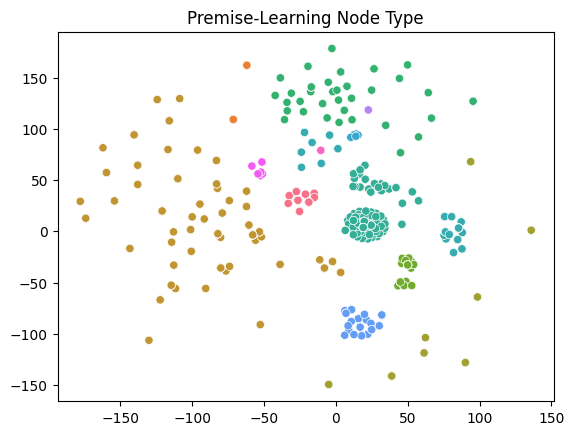

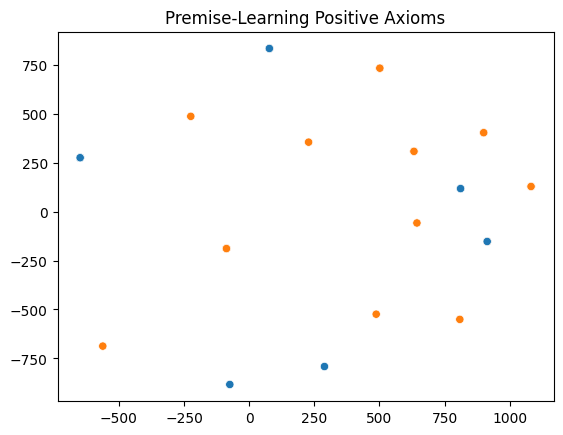

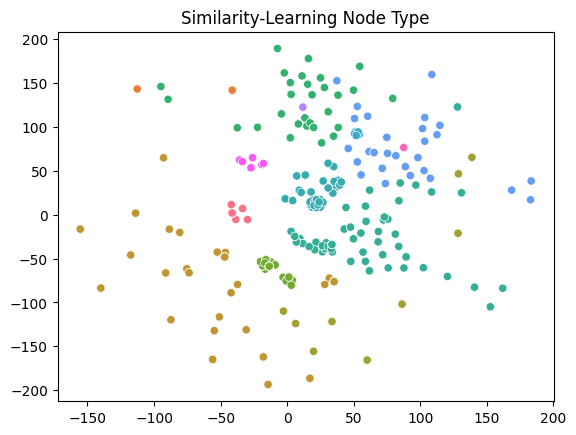

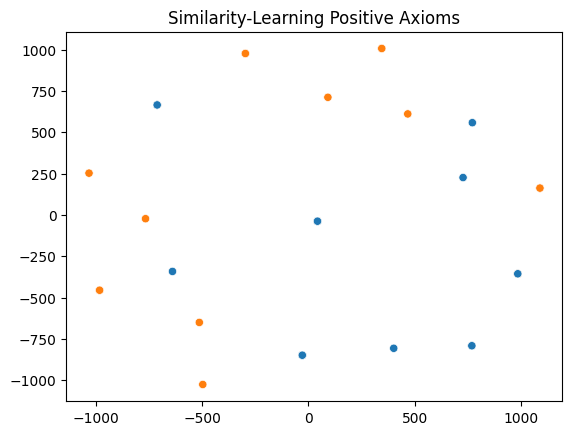

In [17]:
# Can keep same dataset for both (if transforms are the same)
dataset = get_data_loader(IDS, BenchmarkType.DEEPMATH, task=LearningTask.PREMISE, batch_size=4, shuffle=False, in_memory=True, **dataset_params)
    
for pre_title, task, model_path in configs:
    
    # Load model
    model = load_model(model_path, task)
    
    # Embed problems and plot
    plot_embedding(model, dataset, title_prefix=pre_title)